[*********************100%***********************]  3 of 3 completed
07:40:00 - cmdstanpy - INFO - Chain [1] start processing


Training model for ADRO.JK...


07:40:01 - cmdstanpy - INFO - Chain [1] done processing



Model for ADRO.JK saved as ../models/Prophet_ADRO.JK.pkl



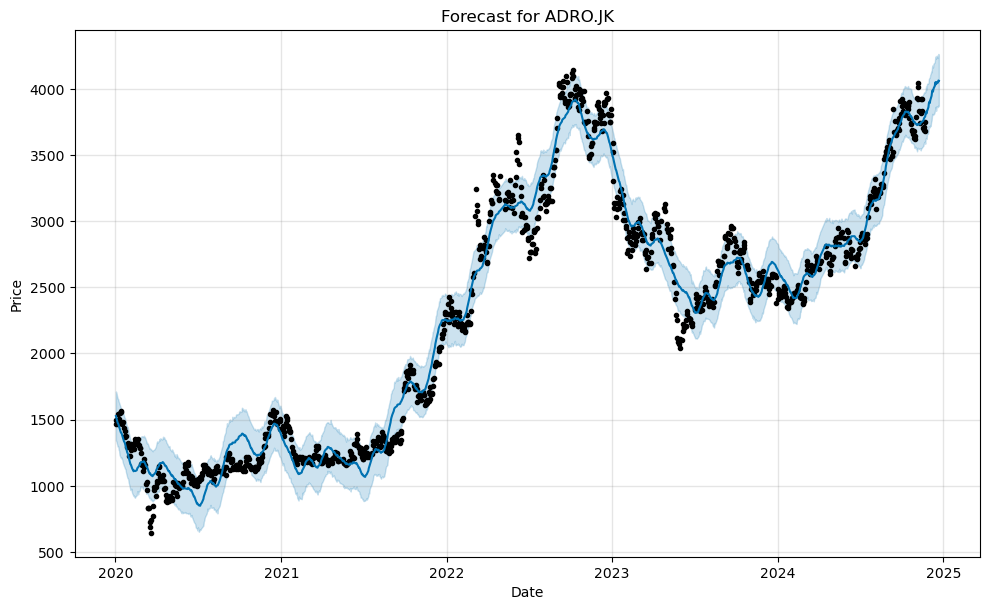

07:40:01 - cmdstanpy - INFO - Chain [1] start processing


Plot for ADRO.JK saved as ../outputs/Prophet_ADRO.JK_Forecast.png
Forecast data for ADRO.JK saved as ../outputs/Prophet_ADRO.JK_Forecast.csv
Training model for BBCA.JK...


07:40:01 - cmdstanpy - INFO - Chain [1] done processing



Model for BBCA.JK saved as ../models/Prophet_BBCA.JK.pkl



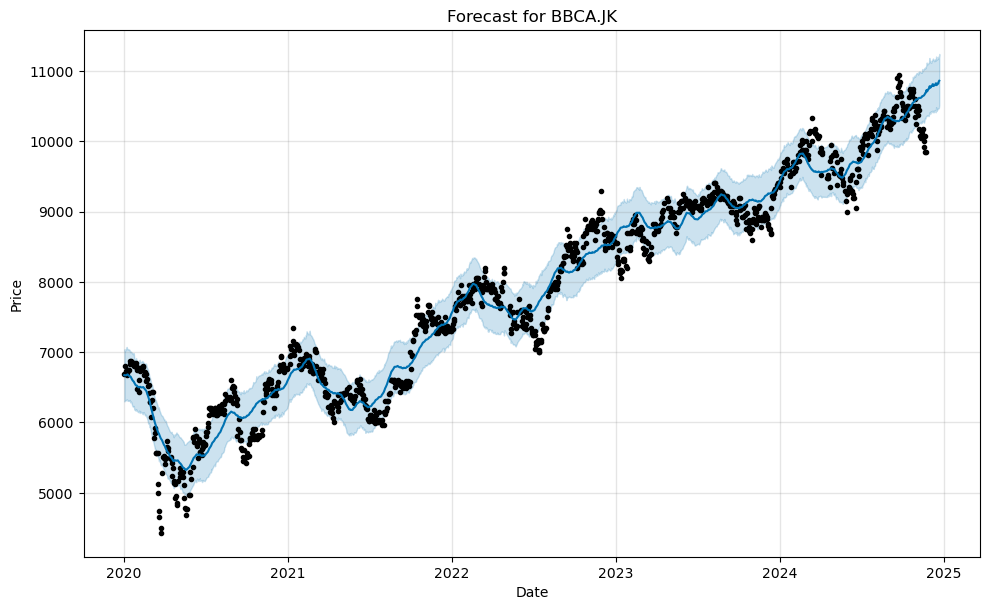

07:40:02 - cmdstanpy - INFO - Chain [1] start processing


Plot for BBCA.JK saved as ../outputs/Prophet_BBCA.JK_Forecast.png
Forecast data for BBCA.JK saved as ../outputs/Prophet_BBCA.JK_Forecast.csv
Training model for TLKM.JK...


07:40:02 - cmdstanpy - INFO - Chain [1] done processing



Model for TLKM.JK saved as ../models/Prophet_TLKM.JK.pkl



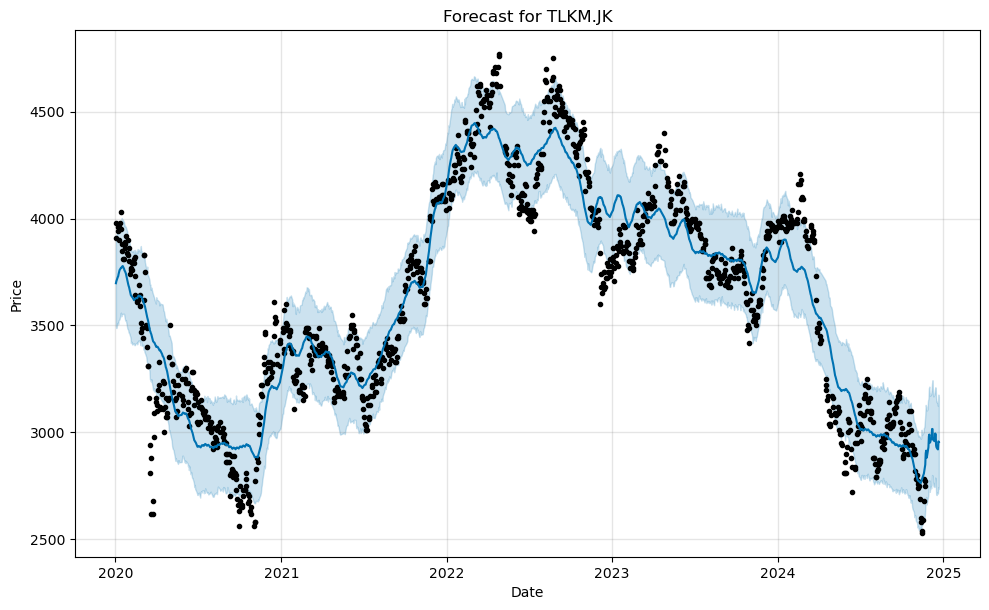

07:40:02 - cmdstanpy - INFO - Chain [1] start processing


Plot for TLKM.JK saved as ../outputs/Prophet_TLKM.JK_Forecast.png
Forecast data for TLKM.JK saved as ../outputs/Prophet_TLKM.JK_Forecast.csv

Forecast for ADRO.JK:
             ds         yhat   yhat_lower   yhat_upper
1213 2024-12-18  4048.309749  3861.190285  4241.911655
1214 2024-12-19  4047.027655  3864.921574  4251.617052
1215 2024-12-20  4046.111734  3860.931245  4232.253722
1216 2024-12-21  4062.101133  3873.469956  4262.946658
1217 2024-12-22  4059.991736  3869.736800  4253.852672

Forecast for BBCA.JK:
             ds          yhat    yhat_lower    yhat_upper
1213 2024-12-18  10812.275764  10453.232101  11175.078147
1214 2024-12-19  10822.928527  10465.993319  11202.908508
1215 2024-12-20  10824.066502  10467.042598  11173.552762
1216 2024-12-21  10853.549620  10470.071366  11193.916883
1217 2024-12-22  10861.474597  10511.545450  11243.329245

Forecast for TLKM.JK:
             ds         yhat   yhat_lower   yhat_upper
1213 2024-12-18  2926.373971  2718.140688  3139.701552
12

07:40:03 - cmdstanpy - INFO - Chain [1] done processing


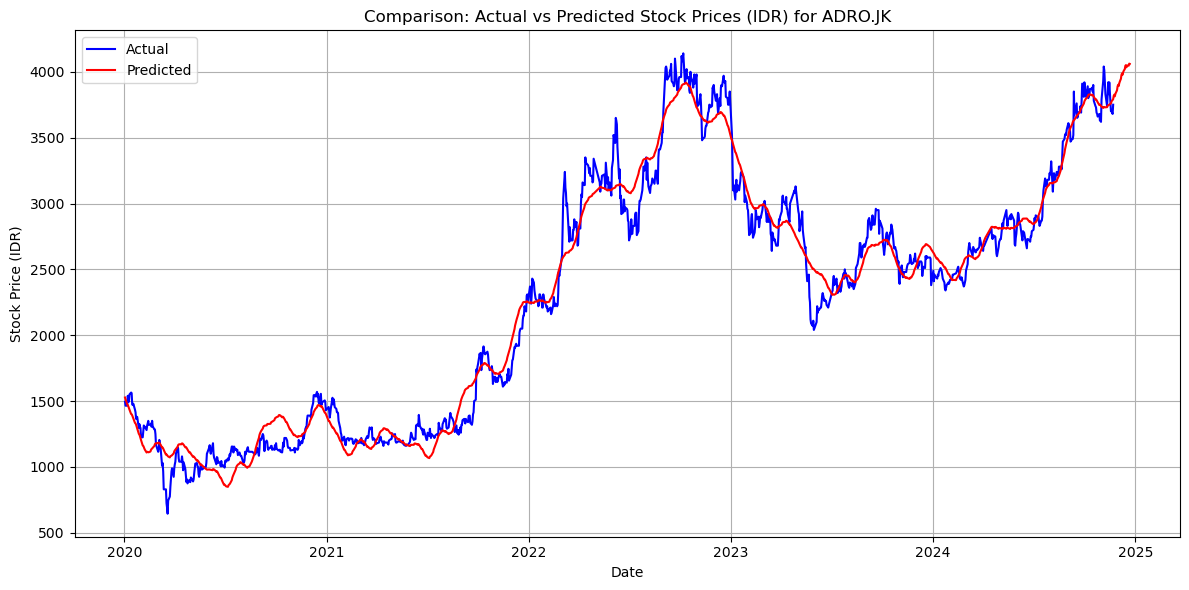

07:40:03 - cmdstanpy - INFO - Chain [1] start processing
07:40:03 - cmdstanpy - INFO - Chain [1] done processing


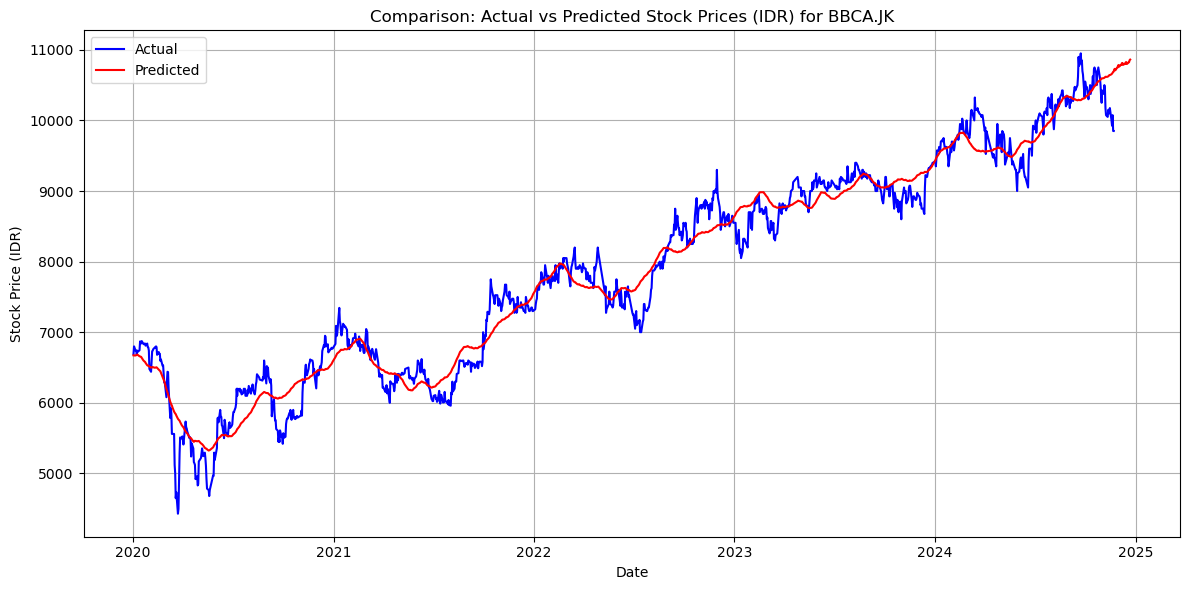

07:40:04 - cmdstanpy - INFO - Chain [1] start processing
07:40:04 - cmdstanpy - INFO - Chain [1] done processing


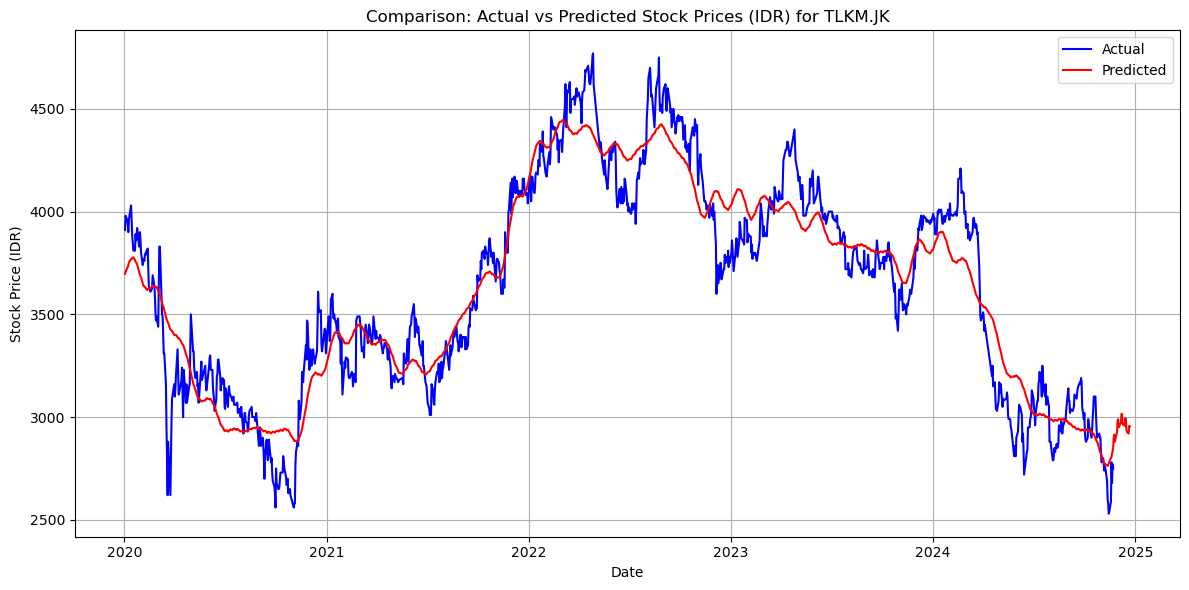

In [1]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle

start_time = datetime.now()

tickers = ['ADRO.JK', 'BBCA.JK', 'TLKM.JK']
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download yfinance stock data
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', interval='1d')

# Align MultiIndex columns to single-level columns
data.columns = ['_'.join(col).strip() for col in data.columns]

# Select the Close price for each ticker
close_prices = data.filter(like='_Close')

# Train a model for each stock
future_periods = 30  # 

# Prophet model training function
def train_and_forecast(df, ticker, future_periods):
    # Data format for Prophet
    
    df_prophet = df.reset_index()[['Date', f'{ticker}_Close']]
    df_prophet.columns = ['ds', 'y'] 

    df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None) # remove timezone

    # Create Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(df_prophet)

    # Save the model
    model_filename = f"../models/Prophet_{ticker}.pkl"
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"\nModel for {ticker} saved as {model_filename}\n")

    # Create a dataframe for a future period
    future = model.make_future_dataframe(periods=future_periods)

    # Prediction
    forecast = model.predict(future)

    # Plot result
    fig = model.plot(forecast)
    plt.title(f"Forecast for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

    # Plot result
    fig = model.plot(forecast)
    plt.title(f"Forecast for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plot_filename = f"../outputs/Prophet_{ticker}_Forecast.png"
    plt.savefig(plot_filename)
    print(f"Plot for {ticker} saved as {plot_filename}")
    plt.close(fig)  # Close the plot to free memory

    # Save the forecast data to CSV
    forecast_filename = f"../outputs/Prophet_{ticker}_Forecast.csv"
    forecast.to_csv(forecast_filename, index=False)
    print(f"Forecast data for {ticker} saved as {forecast_filename}")

    return forecast

# Execute model for each ticker
results = {}
for ticker in tickers:
    print(f"Training model for {ticker}...")
    forecast = train_and_forecast(close_prices, ticker, future_periods)
    results[ticker] = forecast

# Show prediction result
for ticker in results:
    print(f"\nForecast for {ticker}:")
    print(results[ticker][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("")


# Comparison of Actual vs Predicted Stock Prices (IDR) 

for ticker in tickers:
    # Select Close prices for the ticker
    close_prices = data.filter(like=f'{ticker}_Close')
    close_prices = close_prices.reset_index()[['Date', f'{ticker}_Close']]
    close_prices.columns = ['ds', 'y']  # Rename columns for Prophet

    # Remove timezone information from dates
    close_prices['ds'] = pd.to_datetime(close_prices['ds']).dt.tz_localize(None)

    # Train Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(close_prices)

    # Create future dataframe
    future = model.make_future_dataframe(periods=future_periods)
    forecast = model.predict(future)

    # Merge actual and predicted values
    df_compare = pd.merge(close_prices, forecast[['ds', 'yhat']], on='ds', how='outer')

    # Display and save
    plt.figure(figsize=(12, 6))
    plt.plot(df_compare['ds'], df_compare['y'], label='Actual', color='blue')
    plt.plot(df_compare['ds'], df_compare['yhat'], label='Predicted', color='red')
    plt.title(f'Comparison: Actual vs Predicted Stock Prices (IDR) for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (IDR)')
    plt.legend()
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../outputs/Prophet_{ticker}_Comparison.png")
    plt.show()
    plt.close() 
   
    # Save the combined data to forecast_recent
    forecast_recent = df_compare.copy()
